# Food-101 Classification

## Summary

In trying to train a classifier on the Food-101 dataset, I tried several iterations of different augmentation strategies. Full notebooks for these experiments are located in the [Experiments](https://github.com/kheyer/Food101-Classification/tree/master/Experiments) directory. This is a summary of results:

| Notebook 	| Image Augmentation 	| Mixup Augmentation 	| Label Smoothing 	| Top-1 Accuracy 	| TTA Top-1 Accuracy 	|
|:--------:	|:------------------:	|:------------------:	|:---------------:	|:--------------:	|:------------------:	|
|    EX1   	|          1         	|          0         	|        0        	|      88.53     	|        89.26       	|
|    EX2   	|          0         	|          1         	|        1        	|      88.32     	|        88.75       	|
|    EX3   	|          1         	|          1         	|        1        	|      89.28     	|        89.70       	|
|    EX4   	|          1         	|          1         	|        0        	|      89.09     	|        89.79       	|

This notebook details the process for training the model from the `EX4` notebook, which achieved the highest test set accuracy.

## Model Training

In the previous notebook, we identified several features of the Food-101 dataset that makes it particularly challenging. The dataset is small, consisting of only 750 training images per class. Many of the images are amateur photographs with bad lighting or framing. There is high variability of images within a single class. A single image may also contain multiple classes (ie Hamburger and Fries) despite there being only one correct label for the image. There are also classes that contain high visual similarity to each other.

To train a model that is robust to these challenges, we need to use a few tricks.

### Image Augmentation
This will be our main method of attacking the small dataset. We will use an aggressive set of image augmentations to artificially expand the dataset. Using augmentations like flipping, rotating, warping, and contrast changes create new variants of the data that allow us to train longer and avoid overfitting.

### Mixup

[Mixup](https://arxiv.org/pdf/1710.09412.pdf) uses a simple but powerful technique to augment images. We create augmented images by taking two images and linearly interpolating between them. We then train the model to predict a linear interpolation of the targets. Concretely:

    new_image = t * image1 + (1-t) * image2
    new_target = t * target1 + (1-t) * target2
    
Where `t` is a value between 0 and 1 that is likely close to 0 or close to 1. The exact details of how `t` is chosen are described below. Mixup provides extremely strong regularization and is also fast to compute - you just interpolate between two images entirely on the GPU.

### Weight Decay

Weight decay penalizes the model for having large weights. Ordinarily weight decay is thought of as a form of regularization, but we will be using a pretrained Resnet50 model that includes batchnorm layers. One weird side effect of batchnorm is it prevents weight decay from having a regularizing effect by scaling activations to have a mean of 0 and a variance of 1 regardless of the scale of the weights. While weight decay no longer regularizes, it is still important for training. Without a weight decay term, the norm of the model's weights will increase over time. Given that the gradients of a batchnorm layer have the curious property that 

   $\frac{\delta Batchnorm(\alpha x)}{\delta w_{i}}  = \frac{1}{\alpha}  \frac{\delta Batchnorm(x)}{\delta w_{i}}$
   
Increasing weights lead to smaller gradients, which lower the effective learnign rate and can grind training to a halt. We apply weight decay to limit the magnitude of $\alpha$ and prevent this effect. For more on the weird interplay between weight decay and batchnorm, see [L2 Regularization versus Batch and Weight Normalization](https://arxiv.org/abs/1706.05350).

### Dropout

Dropout is a common form of regularization that applies a mask to a given layer's activations that randomly zeros out activations with some probability $p$. This forces the model to learn multiple mappings from activations to output, helping to prevent overfitting.


### Progressive Resizing

First we will train on images at 256x256 resolution. After several epochs, we will scale up to 512x512 resolution. Resizing alters the receptive field of the convolutional kernels in the network relative to actual feature sizes on the image. In practice this allows us to train longer without overfitting.

### One Cycle Learning Rate Scheduling

The One Cycle training policy comes from the paper [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay](https://arxiv.org/abs/1803.09820) by Leslie Smith. The paper finds that following a particular schedule for learning rate and momentum leads to faster convergence and better generalization. The learning rate starts at a small value, and is then ramped up to a maximum, after which the learning rate is ramped back down. Momentum is scheduled in the opposite fashion, starting high, ramping down, then ramping back up. The paper finds that approximations of the Hessian are smaller when this method is used, indicating that the model has found a flatter part of the loss landscape which should generalize better. We will train the model using this technique.

### Test Time Augmentation

We will predict on the test set using test time augmentation. This means that for each image in the test dataset, we will predict on several augmented versions of the image and average their prediction scores.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from shutil import copyfile
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

In [3]:
bs = 96

In [4]:
path = Path('../data/food-101/')
path_img = path/'images'
path_meta = path/'meta'

In [5]:
path_train = path/'data/train'

# Creating the Dataloader

We will use the fast.ai library for creating our dataloader and training our model. fast.ai has a nice image augmentation pipeline that we can use to manage our augmentation. Here we set the parameters for the different augmentation functions `do_flip`, `flip_vert`, `max_rotate`, `max_zoom`, `max_lighting` and `max_warp`. What exactly these functions do will be explained below.

In [10]:
tfms = get_transforms(
                        do_flip=True,
                        flip_vert=True,
                        max_rotate=10.0,
                        max_zoom = 1.1,
                        max_lighting=0.25,
                        max_warp=0.25,
                        )

Here we create our dataloader. In doing so we split the test data into training and validation sets. We can't use the actual test set as a validation set, that would be cheating.

We take a random 7% validation set, passing a specific random seed to the splitting function to ensure we always get the same split. The 7% validation set leads to a training set of 70448 images and a validation set of 5302 images.

We also set the training image size. We will train on 256x256 images.

In [11]:
data = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=256)
                                       .databunch(bs=bs, num_workers=6))

In [12]:
data

ImageDataBunch;

Train: LabelList (70448 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data\train;

Valid: LabelList (5302 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
clam_chowder,macaroni_and_cheese,tacos,macaroni_and_cheese,lobster_roll_sandwich
Path: ..\data\food-101\data\train;

Test: None

Examining the validation dataset on a per-class basis, it looks like we have an average representation of 52 images per class, which is about what we would expect.

In [19]:
classes = [[i1].obj for i in data.valid_ds]
df = pd.DataFrame(classes, columns=['class'])

In [24]:
df['class'].value_counts().mean(), df['class'].value_counts().std()

(52.495049504950494, 7.180005240076412, 72, 36)

# Image Augmentation Functions

Lets look at what the augmentation functions we defined earlier actually do. First we'll look at the composite effect of all augmentations, then we'll break down each augmentation function individually.

## Composite Augmentations
Here's the full effect of merging zooms, rotations, flips, perspective warping and lighting changes.

In [13]:
def get_ex():
    return open_image(path_train/'spring_rolls/85452.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(data.train_ds.tfms, **kwargs).show(ax=ax) for i, ax in enumerate(plt.subplots(
                                                                        rows, cols, figsize=(width, height))[1].flatten())]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


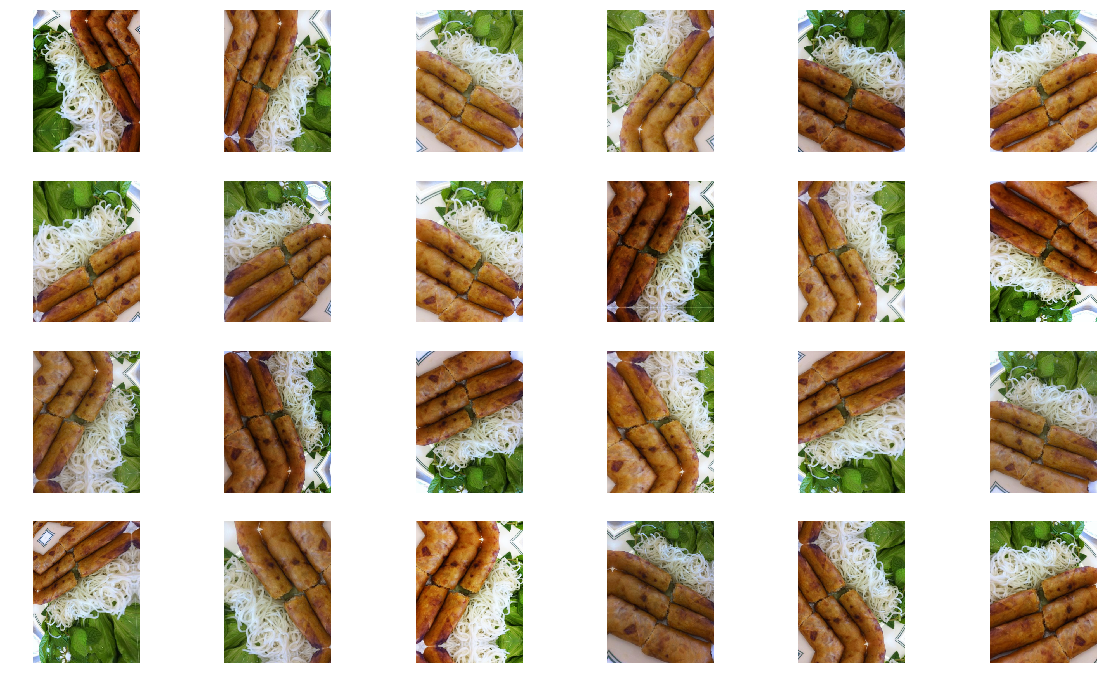

In [14]:
plots_f(4, 6, 20, 12)

# Individual Augmentations

What do these augmentation functions do individually?

In [15]:
def plots_f_indiv(idx, rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(data.train_ds.tfms[idx], **kwargs).show(ax=ax) for i, ax in enumerate(plt.subplots(
                                                                        rows, cols, figsize=(width, height))[1].flatten())]

## Augmentation 1: Dihedral Affine Transformation

Randomly rotates and flips the image. This particular augmentation function only applies discrete 90 degree rotations. The behavior of this function is determined by two parameters we passed in the augmentations list - `do_flip` and `flip_vert`. `do_flip` turns on the Dihedral Affline Transformation, and `flip_vert` specifies that we will flip the image both horizontally and vertically.

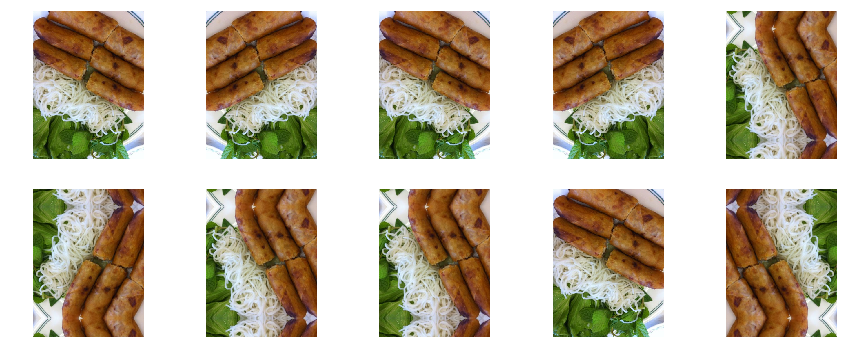

In [16]:
plots_f_indiv(1, 2, 5, 15, 6)

Choosing to pass the `flip_vert` parameter and apply vertical flipping has some interesting implications. Consider how this augmentation looks for the following image:

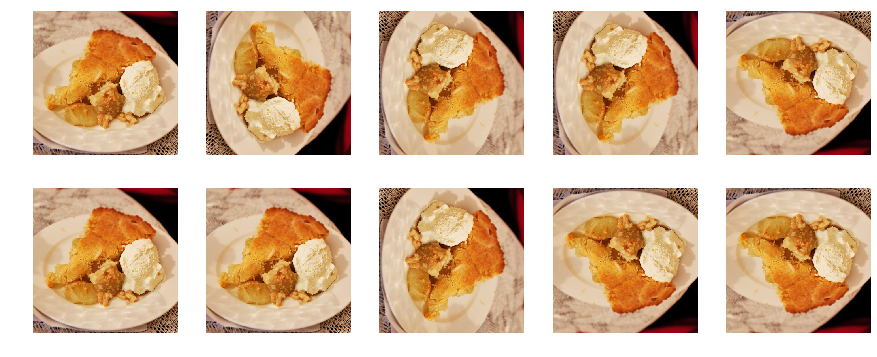

In [17]:
[open_image(path_train/'apple_pie/727412.jpg').apply_tfms(data.train_ds.tfms[1]).show(ax=ax) for i, ax in 
    enumerate(plt.subplots(2,5, figsize=(15,6))[1].flatten())];

Here we take a slice of pie and flip it upsidown. Does this really make sense? The challenge here is that we have certain images in the dataset that work with vertical flipping, and certain images that don't. In playing around with this dataset I experimentally found that including vertical flipping produced slightly better results, so I decided to keep it in the augmentation list.

# Augmentation 2: Symmetric Warp

This function applies different degrees of symmetric warping to the image. If you look at the bottom right corner of some of these images, you can see where pixels have been reflected to account for the image warping.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


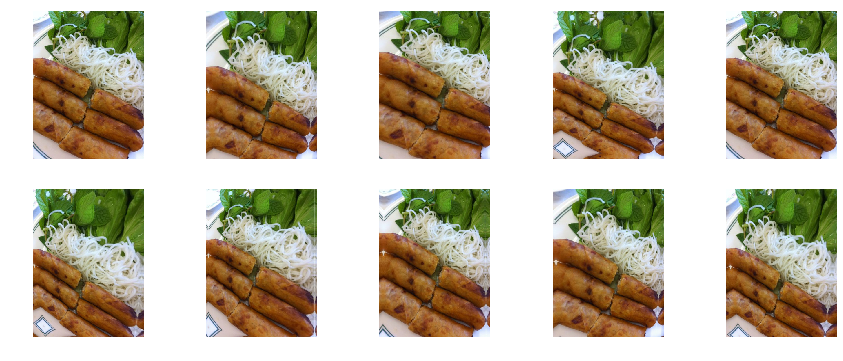

In [20]:
plots_f_indiv(2, 2, 5, 15, 6)

# Augmentation 3: Rotation

This augmentation applies a subtle rotation to the image (subtle relative to the full 90° flips of the dihedral affine transformation). I found that setting the maximum rotation to 10° produced good results. The augmented image will be rotated by up to 10° clockwise or counterclockwise.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


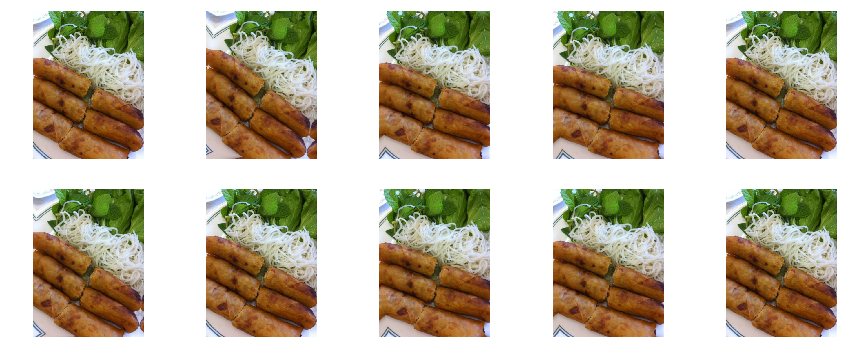

In [21]:
plots_f_indiv(3, 2, 5, 15, 6)

# Augmentation 4: Zoom

This function randomly zooms up to 1.1x the original image. Experimentally I found that higher zooms worked poorly for the dataset. As we saw in the previous notebook, many images in the dataset are not centered. Applying too large of a zoom risks cropping out important parts of the image.

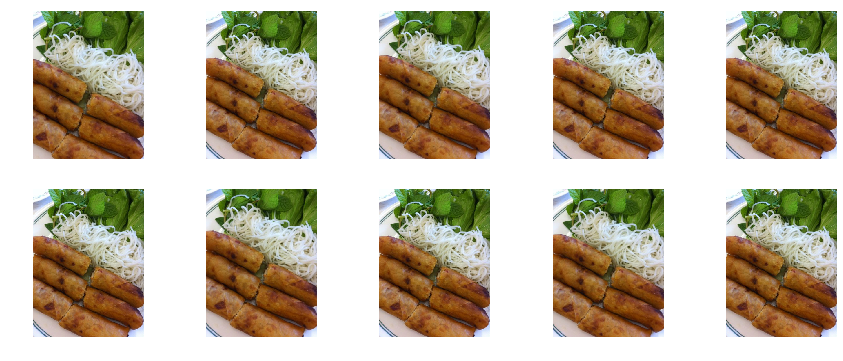

In [22]:
plots_f_indiv(4, 2, 5, 15, 6)

# Augmentation 5: Brightness

This is also a rather subtle augmentation, but important for getting good results. Brightness here is defined by a value between 0 and 1, where 0 transforms the image to black and 1 transforms the image to white. A change of 0.5 does nothing. I found experimentally that adding brightness augmentation helps a lot with accuracy on this dataset. This is likely because many images are overexposed or underexposed, and adding a brightness augmentation can help counteract this. However this also means that we need to be careful in how much we augment brightness. Underexposed images can be made darker, or overexposed images lighter.

I found that letting brightness coefficient vary from 0.375 to 0.625 produced good results.

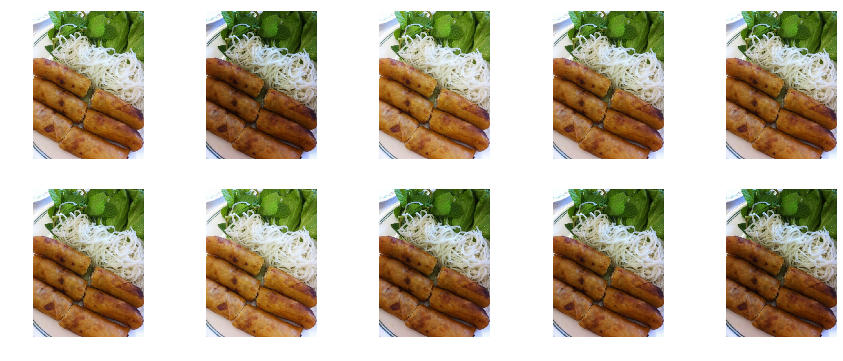

In [23]:
plots_f_indiv(5, 2, 5, 15, 6)

# Augmentation 6: Contrast

Similar to brightness, contrast is defined by a value between 0 and 1 where 0 is greyscale, 1 is no change, and a value greater than 1 leads to super-contrast. Also similar to brightness, we need to be careful with how much contrast we apply. The right amount yields great results, while too much hurts performance.

I found letting contrast vary from 0.75 to 1.33 produced good results.

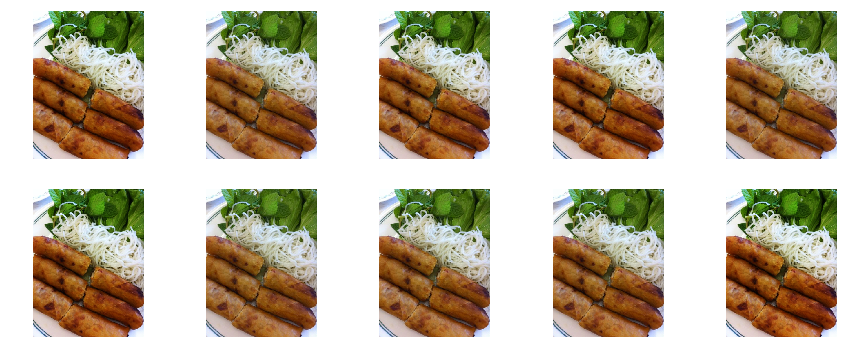

In [24]:
plots_f_indiv(6, 2, 5, 15, 6)

# Mixup Augmentation, in Detail

In addition to the augmentations above, we will use mixup augmentation. We create our mixed up image following 

    new_image = t * image1 + (1-t) * image2
    
Lets sweep through a range of `t` values to see what that looks like

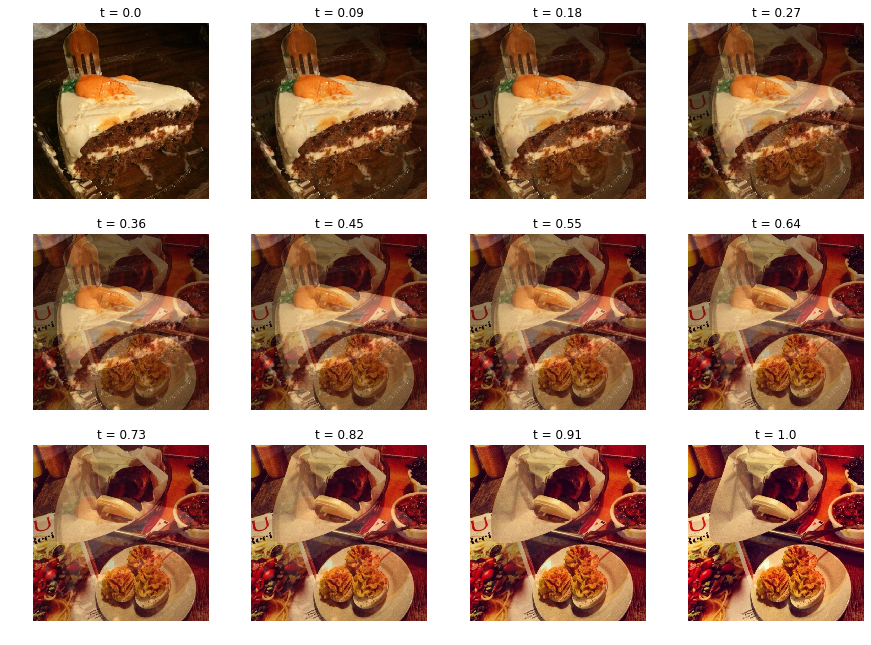

In [12]:
ts = list(np.linspace(0,1,12))

fig, axes = plt.subplots(3,4, figsize=(15,11))

for i, ax in enumerate(axes.flat):
    t = ts[i]
    mix = t*data.train_ds.x[1000].data + (1-t)*data.train_ds.x[10000].data
    show_image(mix, ax=ax)
    ax.set_title('t = ' + str(round(t,2)))

When `t` is close to 0 or close to 1, the mixed up image looks visually very similar to the original image. At `t` values close to 0.5, there's a strong visual difference. We tune the regularization of mixup by changing the probability distribution of `t` values. So how exactly do we do this?

## Selecting t

Following the Mixup paper, `t` is drawn from a beta distribution with an $\alpha$ value between 0.1 and 0.4. Using a beta distribution ensures that most of the time, `t` will be close fo 0 or close to 1, leading to moderate mixup. Increasing the $\alpha$ parameter increases the probability that `t` will be closer to 0.5.

Plotting the beta distribution for different alpha values:

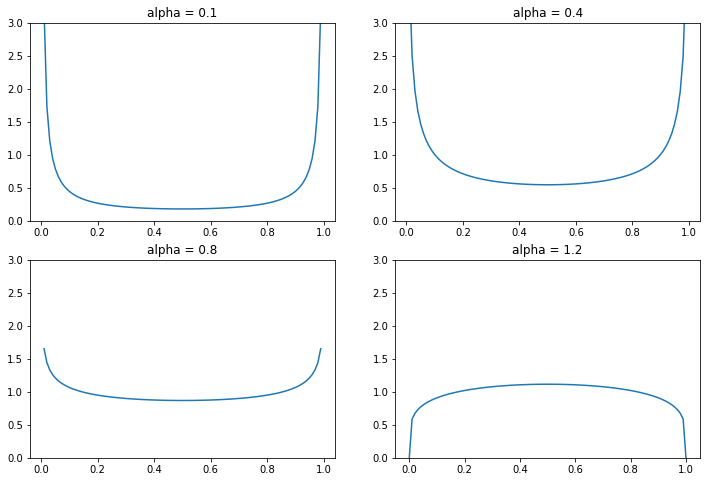

In [13]:
alphas = [0.1, 0.4, 0.8, 1.2]
x = torch.linspace(0,1,100)

fig, axes = plt.subplots(2,2, figsize=(12,8))

for i, ax in enumerate(axes.flat):
    alpha = tensor(alphas[i])
    B = alpha.lgamma().exp() * alpha.lgamma().exp() / (2*alpha).lgamma().exp()
    y = x**(alpha - 1) * (1-x)**(alpha - 1) / B
    ax.plot(x.numpy(), y.numpy())
    ax.set_title("alpha = " + str(alphas[i]))
    ax.set_ylim([0,3])

For training, we will use an $\alpha$ value of 0.4. For each batch of training data, we will draw a `t` value for each item in the batch from the beta distribution defined by $\alpha$. This gives each item in the batch a different degree of mixup.

We will use the fast.ai library to implement mixup. One detail to note is that fast.ai implements mixup on a per-batch basis. This means that mixup occurs between elements within a batch rather than over the entire dataset.

## Loss Function for Mixup

We need a loss function that implements mixup during the loss calculation following the same `t` parameters used to mixup the inputs. For example if we mixed up two images with ground truth values `[1,0,0,0]` and `[0,0,1,0]` with a value of `t=0.7`, we would want to perform our cross entropy calculation against a ground truth value of `[0.7,0,0.3,0]`. Unfortunately cross entropy in Pytorch is designed to take integer values for the ground truth. The workaround is to calculate cross entropy twice - once for each element in the mixup - and interpolate the values. Following the above example, we would have:

    loss = 0.7*ce(prediction, 0) + 0.3*ce(prediction, 2)
    
Where `ce` is the cross entropy function.

# Model Training

Now that we have our loss function and image augmentations in hand, we can proceed to training the model. With a dataset of this size, training from scratch would likely lead to overfitting and disaster. To avoid this, we will start with a pre-trained Resnet-50 model.

Why Resnet-50? It's a solid architecture with a good balance of size and performance. The model performs well without the weight that comes with VGG or Inception type architectures. It has all the benefits of resnets without the weight of a Resnet-101 type model. Or to quote [Andrej Karpathy](https://karpathy.github.io/2019/04/25/recipe/),

    "Don't be a hero ... just copy paste a ResNet-50 for your first run"

To transfer the pre-trained model to the Food-101 dataset, we will replace the final linear layers at the end of the model with ones compatible for the Food-101 dataset's 101 classes. We will then train the model in two phases.

First we will freeze the pretrained weights of the model and train only the new linear layers we added to the model. We do this because the linear layers are totally untrained and naive, so allowing those layers to backpropagate gradients into the well tuned pretrained layers of the model will likely do more harm than good. We want to train the linear layers to a point where they are performing decently before retraining the entire model.

Second, we unfreeze the entire model and train with discriminative learning rates. This means we will train the early layers of the model at a lower learning rate than the higher layers. We do this because the early layers only do fundamental feature extraction - identifying curves, edges, changes in intensity, etc. These layers are already well tuned and don't need to be aggressively trained. The later layers, which are trained to extract information for Imagenet classes, will be retrained at a higher learning rate. The final linear layers will receive the highest learning rate.

Each training phase follows the One Cycle learning rate scheduling described above.

We instantiate the model with a `Learner` object from the fast.ai library.

In [13]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn = learn.mixup()

When we created the learner, several values were passed to the model that are worth noting. Firstly, we will be using a weight decay coefficient of 5e-3. With respect to weight decay, the fast.ai library implements weight decay using the gradient update format rather than the L2 regularization format.

The L2 regularization format adds the weight decay term directly to the loss:

$L_{\text total} = \Big(L + \lambda||w||_2^2\Big)$

While the gradient update format only adds in the weight decay term when the weights are updated:

$w_{i+1} = w_i - 2 \lambda w_i - \Big<\frac{\delta L}{\delta w}|_{w_i}\Big>$

If you use a simple optimizer like SGD, these methods are equivalent. However, we will be training with the Adam optimizer, which accumulates gradients over multiple timesteps. When we add in gradient accumulation to our optimizer, the two weight decay formats become different. With the L2 Regularization format, the weight decay term is included in all our accumulated gradients. With the gradient update format, weight decay does not impact the gradients. 

The impact of this effect was explored in [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101), which found the gradient update format produced better results.

In [14]:
learn.wd

0.005

We also defined the level of dropout we will use in the new linear head. Specifically the linear head looks like this:

In [15]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

We use dropout values of 0.2 and 0.4.

The full model looks like this:

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

Our loss function is cross entropy, described earlier

In [15]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

We will also train in FP16

In [31]:
learn = learn.to_fp16(dynamic=True);
learn.freeze()

To select our learning rate, we will use the learning rate finder utility in the fast.ai library. This sweeps through a wide range of possible learning rates, looking at how the loss evolves as a function of learning rate.

Looking at the plot of loss vs learning rate, we see three distinct regions.

At a low learning rate, our loss is mostly flat. This range of learning rates is too low.

In the middle, we see a section where the learning rate starts to drop. This represents a good range of learning rates.

At the end, we see the loss start to increase again. This is the point where the learning rate is too high.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


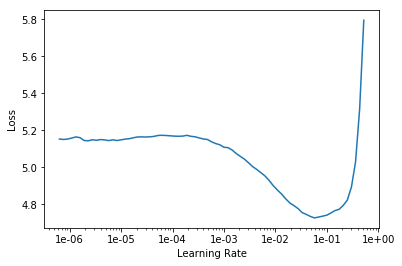

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(8, max_lr=slice(1e-2))

These plots show the learning rate and momentum scheduling for the One Cycle training technique

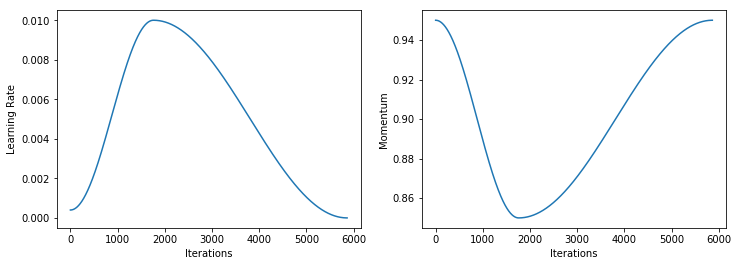

In [19]:
learn.recorder.plot_lr(show_moms=True)

In [20]:
learn.save('food_mix_aug_nls-1')

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(12, max_lr=slice(1e-5,1e-3))

In [23]:
learn.save('food_mix_aug_nls-2')

In [17]:
learn.load('food_mix_aug_nls-2');

This is the end of the first stage of training. Now is a good time to check in on the model. We can use some useful methods from the fast.ai library to examine how our model performs and see the areas where it fails.

In [24]:
interp = ClassificationInterpretation.from_learner(learn.to_fp32())
losses,idxs = interp.top_losses()

This plot shows the 'top losses' on the validation set. These are examples where the model was both wrong and highly confident in the wrong answer. The format of the titles for each subplot is `predicted category`/`correct category`/`loss`/`probability of correct category`.

Looking at the plot, the first thing that jumps out is a number of mislabeled examples.

On the top left, we have a photo of what is obviously a hamburger and french fries. The model predicts hamburger, but apparently the correct class is omelette? Turns out that image is `1186923.jpg` and according to the `train.json` file, the correct class for that image is omelette.

On the top middle, we have some sort of dessert. The model classifies this as cheesecake. Apparently the correct class is onion rings? That image is `1564732.jpg` and according to `train.json` the correct class for that image is onion ring.

There are also images that are just plain hard to define. Look at the top right - that image is labeled as a cannoli. I've never seen a cannoli in red sauce in a tin. I honestly have no idea what that is.

On the middle left, there's some sort of salad. The correct label for this image is caprese salad, which I disagree with. That salad has what look like mandarin oranges and cranberries - that's not a caprese. The model thinks it's a beet salad, which I also think is wrong.

In the middle middle, there's a cup of something. I'd wager that's not actually ravioli.

The bottom left looks like deviled eggs, which is another class in the dataset, but the image is labeled as eggs benedict.

The bottom middle is some kind of red meat, but it's not beef tartate.

The bottom right is a mystery to me.

Looking at the top losses shows the challenges of the dataset. The model is expected to learn all these weird edge cases, with a good deal of label noise mixed in.

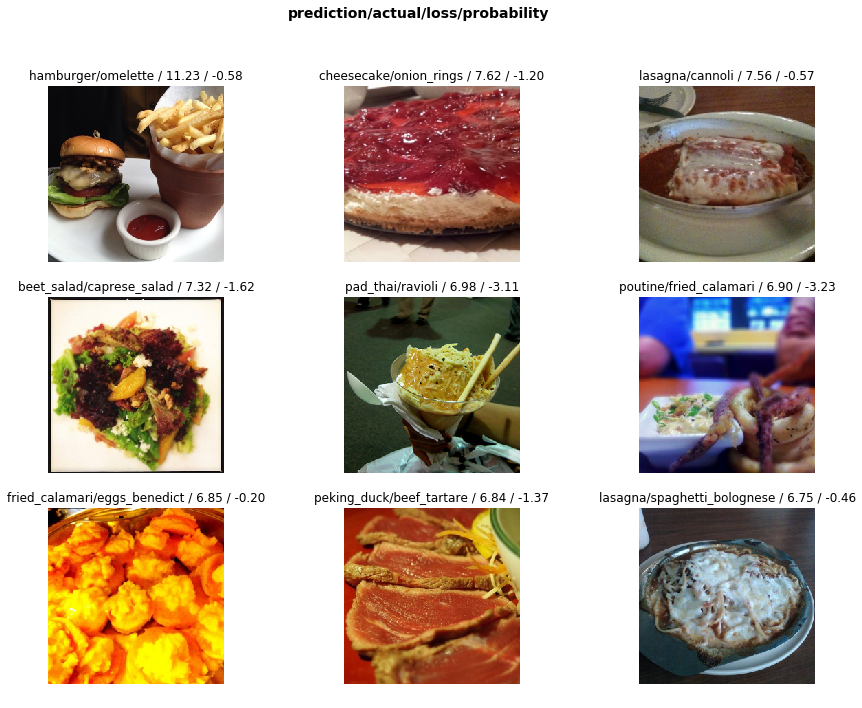

In [27]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

Aside from top losses, we can look at the classes the model struggles to distinguish. Below is a list of the 'most confused' classes - classes that the model frequently mixes up. Here we really see the impact of similar classes. Chocolate cake vs chocolate mousse. Steak vs filet mignon. Steak vs prime rib. Sashimi vs sushi. Beef tartare vs tuna tartare. These are the mixups that will be difficult to iron out.

In [25]:
interp.most_confused(min_val=4)

[('dumplings', 'gyoza', 10),
 ('prime_rib', 'steak', 9),
 ('chocolate_cake', 'chocolate_mousse', 8),
 ('filet_mignon', 'steak', 6),
 ('ice_cream', 'chocolate_mousse', 6),
 ('steak', 'filet_mignon', 6),
 ('steak', 'prime_rib', 6),
 ('beef_tartare', 'tuna_tartare', 5),
 ('cheesecake', 'strawberry_shortcake', 5),
 ('gnocchi', 'ravioli', 5),
 ('ice_cream', 'frozen_yogurt', 5),
 ('pulled_pork_sandwich', 'hamburger', 5),
 ('sushi', 'sashimi', 5),
 ('french_toast', 'bread_pudding', 4),
 ('huevos_rancheros', 'breakfast_burrito', 4),
 ('huevos_rancheros', 'croque_madame', 4),
 ('pho', 'ramen', 4),
 ('pork_chop', 'steak', 4),
 ('red_velvet_cake', 'cup_cakes', 4),
 ('scallops', 'foie_gras', 4),
 ('steak', 'pork_chop', 4),
 ('tuna_tartare', 'beef_tartare', 4)]

# Training on 512x512

Following our strategy of progressive resizing, we will now train on 512x512 images. We will follow a similar training strategy as before. First we will train only the linear head. Then we will unfreeze and train the entire model.

In [28]:
# Important to pass the same random seed to ensure we're using the same validation set
data_hr = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=22, num_workers=6))

In [29]:
data_hr

ImageDataBunch;

Train: LabelList (70448 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data\train;

Valid: LabelList (5302 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
clam_chowder,macaroni_and_cheese,tacos,macaroni_and_cheese,lobster_roll_sandwich
Path: ..\data\food-101\data\train;

Test: None

In [30]:
learn.data = data_hr
learn = learn.to_fp16(dynamic=True)
learn.freeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


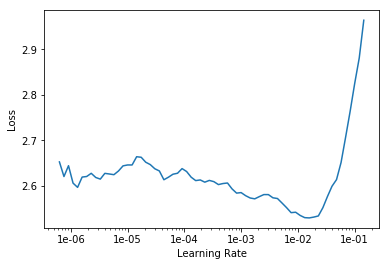

In [32]:
learn.recorder.plot(skip_end=10)

In [32]:
learn.fit_one_cycle(5, max_lr=slice(3e-3))

In [34]:
learn.save('food_mix_aug_nls-3')

In [35]:
learn.unfreeze()

In [35]:
learn.fit_one_cycle(15, max_lr=slice(1e-6,1e-4))

In [39]:
learn.save('food_mix_aug_nls-4')

In [39]:
learn.fit_one_cycle(10, max_lr=slice(5e-7,5e-5))

In [64]:
learn.save('food_mix_aug_nls-5')

At this point I stopped training - the model is struggling to decrease the loss. I experimented with decreasing the regularization and training beyond this point, but I found it detrimental to performance.


# Prediction

We will predict on the test set twice - once without TTA and once with TTA.

## Prediction Without TTA

Here we make a prediction dataloader that contains the test set.

In [39]:
tfms = get_transforms(
                        do_flip=True,
                        flip_vert=True,
                        max_rotate=10.0,
                        max_zoom = 1.1,
                        max_lighting=0.25,
                        max_warp=0.25,
                        )

In [42]:
data_test = (ImageList.from_folder(path/'data').split_by_folder(train='train', valid='test')
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=64, num_workers=6))

In [43]:
learn.data = data_test

In [44]:
learn.data

ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data;

Test: None

In [45]:
learn = learn.to_fp32()

In [46]:
preds, y = learn.get_preds()

In [47]:
accuracy(preds, y)

tensor(0.8909)

Prediction without TTA gets us to 89.09% accuracy.

## Prediction with TTA

Now we predict using TTA. This process will perform 9 predictions. One set of predictions will be on the test set without augmentations. The remaining 8 predictions will be on augmented versions of the test set images. Our final prediction is generated by linearly interpolating between the unaugmented prediction and the average of the augmented predictions. We use the parameter `beta` to control the interpolation. With `beta = 0.4`, we take 40% of the unaugmented prediction and 60% of the average of the augmented predictions.

In [48]:
preds_tta, y_tta = learn.TTA(beta=0.4, scale=1.05)

In [49]:
accuracy(preds_tta, y_tta)

tensor(0.8979)

Using TTA we increase our accuracy from 89.09% to 89.79%

# Interpreting Predictions

Top-1 accuracy is the standard metric for evaluating on the Food-101 dataset, but it's important to to look beyond the single number to assess how the model is really performing. Like before, we will look at top losses and most confused classes.

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

Here we see many of the same class confusions that we saw before.

The model is frequently mixing up cuts of meat. Mixups involving steak, filet mignon, pork chops, prime rib and baby back ribs account for a large percentage of total errors. Beef tartare vs tuna tartare is still a problem.

Dessert mixups are also common. Chocolate cake vs chocolate mousse. Bread pudding vs apple pie.

It's hard to think of good ways to make the model robust to these similar classes without training on more data.

In [51]:
interp.most_confused(min_val=9)

[('steak', 'filet_mignon', 46),
 ('filet_mignon', 'steak', 29),
 ('prime_rib', 'steak', 21),
 ('beef_tartare', 'tuna_tartare', 20),
 ('chocolate_cake', 'chocolate_mousse', 20),
 ('steak', 'pork_chop', 20),
 ('chocolate_mousse', 'chocolate_cake', 19),
 ('apple_pie', 'bread_pudding', 16),
 ('tuna_tartare', 'beef_tartare', 16),
 ('dumplings', 'gyoza', 15),
 ('bread_pudding', 'apple_pie', 13),
 ('ramen', 'pho', 13),
 ('breakfast_burrito', 'huevos_rancheros', 12),
 ('falafel', 'crab_cakes', 12),
 ('pork_chop', 'filet_mignon', 12),
 ('pork_chop', 'steak', 12),
 ('ravioli', 'gnocchi', 12),
 ('steak', 'prime_rib', 12),
 ('huevos_rancheros', 'omelette', 11),
 ('ice_cream', 'frozen_yogurt', 11),
 ('nachos', 'tacos', 11),
 ('ravioli', 'lasagna', 11),
 ('frozen_yogurt', 'ice_cream', 10),
 ('grilled_cheese_sandwich', 'club_sandwich', 10),
 ('ice_cream', 'chocolate_mousse', 10),
 ('pork_chop', 'grilled_salmon', 10),
 ('chicken_quesadilla', 'breakfast_burrito', 9),
 ('club_sandwich', 'grilled_cheese_

Looking at the top losses we again see issues with mislabeled images. At first I thought I had made a mistake when splitting out the test set, but all these image-label pairs check out with the `test.json` file.

Analyzing the images:

Top row:
 * `2765133.jpg` is an omelette, fruit and panacakes labeled as deviled eggs
 * `1713987.jpg` is some sort of dessert labeled as pho
 * `1008491.jpg` is an omelette labeled as a pancake
 
Middle row:
 * `2127050.jpg` is ravioli labeled grilled salmon. You could argue that the thing in the middle covered in cheese is grilled salmon, but I think a reasonable observer would look at that image and call it ravioli
 * `76256.jpg` - I think this image is actually correctly labeled, it's just a hard image to identify
 * `2956362.jpg` - I have no clue what this is. I'll give the dataset the benefit of the doubt here
 
Bottom row:
 * `3065825.jpg` is some fried dish labeled as an omelette 
 * `2508636.jpg` is a burger and fries labeled as pizza
 * `185194.jpg` is a multiclass image. It's labeled macaroni and cheese, and I believe the image has maraconi and cheese in the background. There is also tuna tartare in the foreground

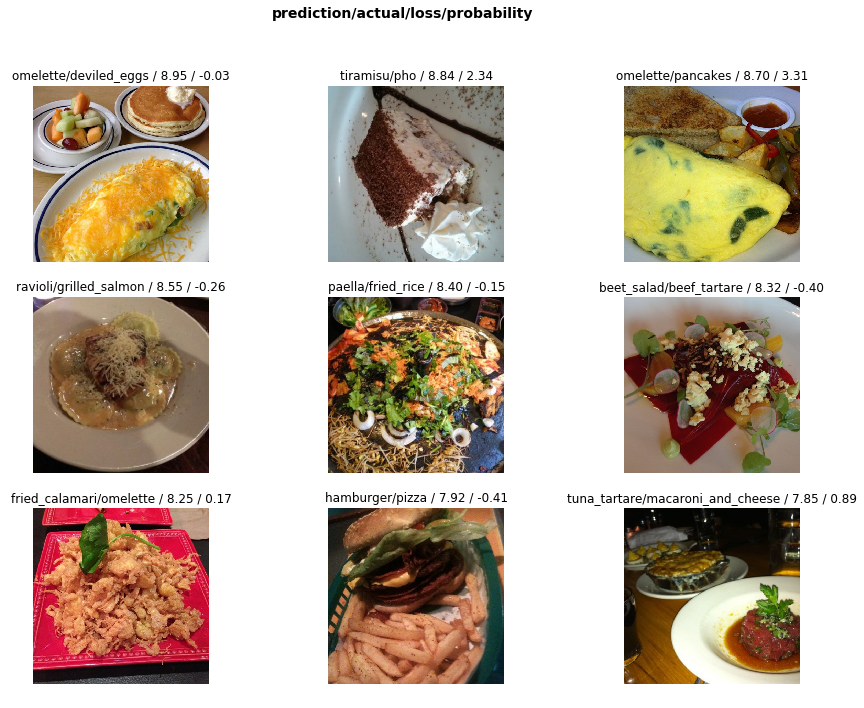

In [65]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

# TSNE Projections

Another interesting way of looking at predictions is to see how they cluster in space when TSNE is applied. We will run TSNE on the prediction vectors from the TTA prediction, meaning they have already had a softmax applied. The softmax has the effect of making every prediction have one value that is close to 1. This leads to pretty good clustering of classes.

In [53]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_tta)

In [54]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x','y','labels'])

This is a cluster over all 25250 predictions, colored by true class. We see most classes cluster well, except for that blob in the middle.

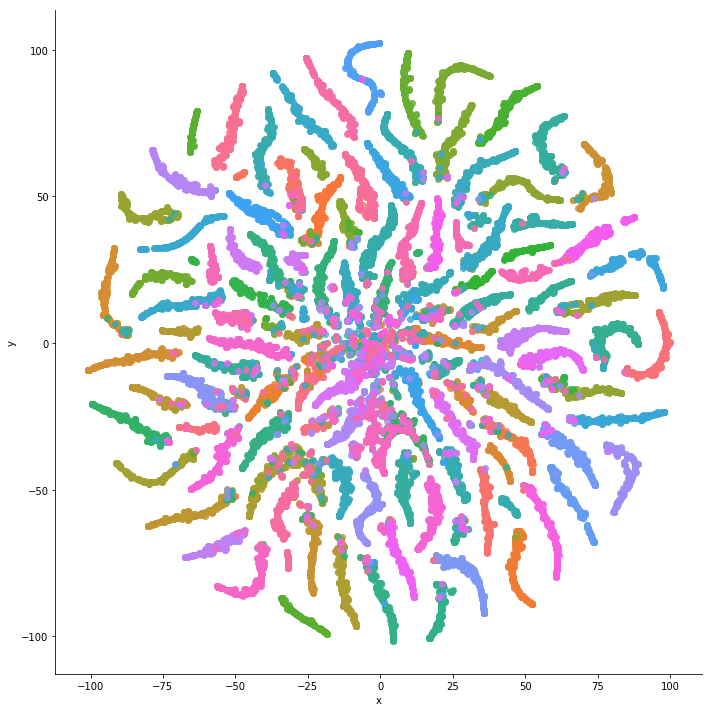

In [56]:
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

Looking at all predictions at once creates a really busy graph. Lets break things down into just a few categories. Here we'll look at the predictions for steak, filet mignon, tuna tartare, beef tartare, prime rib and pork chop classes (label based on the true image label, not the prediction). These classes were chosen as the model frequently confuses them.

In [56]:
cats = ['steak', 'filet_mignon', 'tuna_tartare', 'beef_tartare', 'prime_rib', 'pork_chop']

codes = [data_test.classes.index(i) for i in cats]

bad_preds = [preds_tta[y==i] for i in codes]
bad_ys = [y_tta[y==i] for i in codes]

preds_stack = torch.cat(bad_preds, dim=0)
ys_stack = torch.cat(bad_ys, dim=0)

In [57]:
bad_tsne = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_stack)

In [58]:
bad_df = pd.DataFrame(np.concatenate((bad_tsne, ys_stack[:,None]), axis=1), columns=['x','y','labels'])

With commonly confused classes, we see lots of cluster mixing along the class confusions we saw earlier. For example see how filet mignon and prime rib merge together.

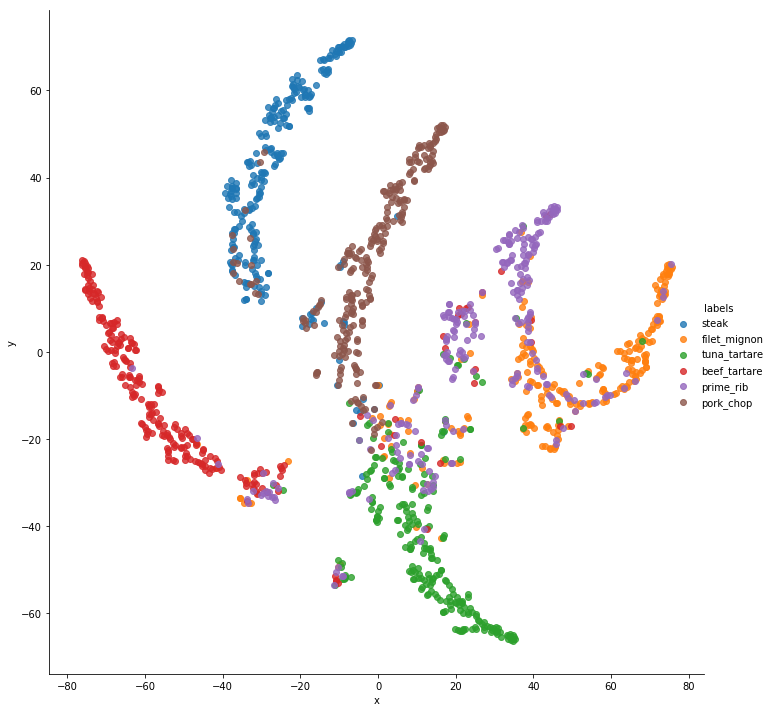

In [60]:
h = sns.lmplot('x', 'y', data=bad_df, hue='labels', fit_reg=False, legend=True, height=10)
for t, l in zip(h._legend.texts, cats): t.set_text(l)


For comparison lets take classes that don't get frequently confused.

In [60]:
cats = ['red_velvet_cake', 'risotto', 'waffles', 'apple_pie', 'garlic_bread', 'french_fries']

codes = [data_test.classes.index(i) for i in cats]

bad_preds = [preds_tta[y==i] for i in codes]
bad_ys = [y_tta[y==i] for i in codes]

preds_stack = torch.cat(bad_preds, dim=0)
ys_stack = torch.cat(bad_ys, dim=0)

In [61]:
bad_tsne = manifold.TSNE(n_components=2, perplexity=10).fit_transform(preds_stack)

In [62]:
bad_df = pd.DataFrame(np.concatenate((bad_tsne, ys_stack[:,None]), axis=1), columns=['x','y','labels'])

With well classified classes, we still see much less cluster mixing

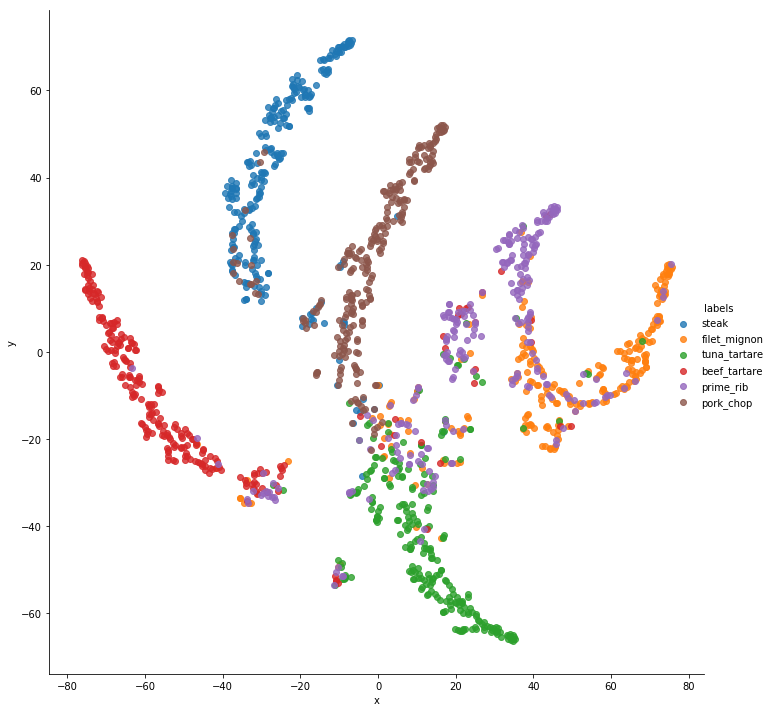

In [60]:
h = sns.lmplot('x', 'y', data=bad_df, hue='labels', fit_reg=False, legend=True, height=10)
for t, l in zip(h._legend.texts, cats): t.set_text(l)
